# Dogs vs. Cats

## Kaggle Competition
[Competition link](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)


# Action Plan

1. Preprocess data
3. Use CNN to classify Dogs and Cats (Transfer Learning)
4. Test and submit predictions

In [2]:
# import of modules and basic notebook config
import os
import sys
import numpy as np
from glob import glob

%matplotlib inline

In [3]:
# references to directories we'll reuse 
current_dir = os.getcwd()
HOME_DIR = current_dir
DATA_DIR = current_dir+'/data'

# 1. Preprocess data

We receive a train.zip and test.zip from Kaggle.

In [ ]:
%ls $DATA_DIR

Let's move 2000 images from our training set to our validation set

In [ ]:
%cd $DATA_DIR
%mkdir valid

In [ ]:
%cd $DATA_DIR/train

In [ ]:
g = glob('*.jpg')

# shuffle array randomly
shuffle = np.random.permutation(g)
for i in range(2000): os.rename(shuffle[i], DATA_DIR+'/valid/' + shuffle[i])

### Rearrange classes into distinct folders

Keras expect classes to be in distinct folders. We'll device cat and dog images into separate directories

In [ ]:
%cd $DATA_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

We'll create a single 'unknown' class for the test set

In [ ]:
%cd $DATA_DIR/test
%mkdir unknown
%mv *.jpg unknown/

___

# 2. Use CNN to classify Dogs and Cats

In [64]:
from keras.preprocessing import image
from PIL import Image
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

#### Data directories:

In [28]:
# path = DATA_DIR + '/sample/'
path = DATA_DIR + '/'
test_path = DATA_DIR + '/test/'
train_path = DATA_DIR + '/train/'
valid_path = DATA_DIR + '/valid/'

 ## 2.1 Train

#### Hyperparameters

In [39]:
batch_size = 256
epochs = 30

### Data augmentation
Generate batches of tensor image data with real-time data augmentation

In [18]:
# function to load batches
def get_batches(path, shuffle=True, batch_size=64, class_mode='categorical'):
    gen = image.ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.15,
                                   zoom_range=0.1,
                                   channel_shift_range=10.,
                                   horizontal_flip=True)
    
    return gen.flow_from_directory(path,
                                   target_size=(224, 224),
                                   class_mode=class_mode,
                                   shuffle=shuffle,
                                   batch_size=batch_size)

In [57]:
train = get_batches(train_path)
valid = get_batches(valid_path)
test = get_batches(test_path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### Data

In [24]:
filenames = train.filenames
print(filenames[:1])

['cats/cat.4745.jpg']


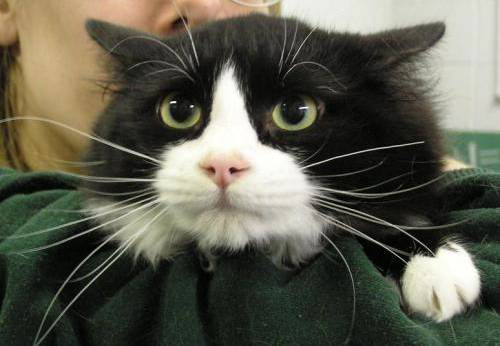

In [25]:
Image.open(train_path + filenames[1])

### Build Model

With our knowledge of transfer learning and ImageNet winner models. Using a Resnet50 model and it's pretrained weights from ImageNet dataset, seems like a great idea for this challenge.

The bottleneck features for ResNet50 is in `bottleneck_features/` folder.
[link to notebook with other bottleneck features](https://github.com/markdyousef/dog-project/blob/master/dog_app.ipynb)

Obtain bottleneck features

In [27]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [34]:
# reference to saved models
SAVE_PATH = 'saved_models/weights.best.Resnet50.hdf5'

#### Finetune Resnet50 and define architecture

###### Build Resnet50 model

In [71]:
train_Resnet50.shape

(6680, 1, 1, 2048)

In [66]:
imagenet_categories = 1000

Resnet50_model = Sequential()
# TODO: this layer should be changed
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(imagenet_categories, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1000)              2049000   
Total params: 2,049,000.0
Trainable params: 2,049,000.0
Non-trainable params: 0.0
_________________________________________________________________


###### Finetune

In [67]:
Resnet50_model.pop()
for layer in Resnet50_model.layers:
    layer.trainable=False

Resnet50_model.add(Dense(train.num_class, activation='softmax'))
Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 4098      
Total params: 4,098.0
Trainable params: 4,098.0
Non-trainable params: 0.0
_________________________________________________________________


#### Compile the Model

In [68]:
Resnet50_model.compile(optimizer='rmsprop',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

#### Train Model

###### Checkpoints

In [69]:
checkpointer = ModelCheckpoint(filepath=SAVE_PATH, verbose=1, save_best_only=True)
tensorboard = TensorBoard()
earlystopper = EarlyStopping(patience=10)

callbacks = [checkpointer, tensorboard, earlystopper]

In [70]:
Resnet50_model.fit_generator(train,
                             steps_per_epoch=train.samples,
                             epochs=epochs,
                             callbacks=callbacks,
                             validation_data=valid,
                             validation_steps=valid.samples//batch_size)

Epoch 1/30


ValueError: Error when checking model input: expected global_average_pooling2d_9_input to have shape (None, 1, 1, 2048) but got array with shape (64, 224, 224, 3)